In [30]:
import math
import pickle
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
import traceback


def isMulti(meas,ind,lenM,lanDik):
    if ind<lenM-1 and meas[ind,0]==meas[ind+1,0] and  int(meas[ind+1,1]) in lanDik:
        return True
    else: 
        return False
def shouldCorrect(mind,kolkuM):
    if mind!=0 or (kolkuM!=0):
        return True
    return False


    
# State of measurement
class M_State:
    First_Multi=0
    Multi=1
    Single=2
    
def isFirstMulti(meas,ind,lenM,lanDik):
    is_multi=isMulti(meas,ind,lenM,landDik)
    
#     if ind==434: print ('all conds', ind<lenM , ind>0 , 
#     meas[ind,0]!=meas[ind-1,0] ,  int(meas[ind-1,1]) in lanDik)
    
    if (is_multi and ind<lenM  and  int(meas[ind,1]) in lanDik) and ( ind==0 or meas[ind,0]!=meas[ind-1,0] ):
        return M_State.First_Multi 
    
    return M_State.Multi if is_multi else M_State.Single 

def bestMeasofBunch(meas,ind,lenM,landDik):
    measCand=[]
    for i in range(ind,lenM):
        measCand.append((i,abs(meas[i][3])))
        if not isMulti(meas,i,lenM,landDik):
            break

    best_c=sorted(measCand,key=lambda x: x[1])
#     if ind<2000: print('best_c',len(best_c)>1)
    return best_c[0][0]



In [31]:

def getAllMulti(dI,Ri=3):
    oName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Odometry.dat'.format(dI,Ri)
    mName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Measurement.dat'.format(dI,Ri)
    gName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Groundtruth.dat'.format(dI,Ri)
    lName='datasets/all_data/MRCLAM_Dataset{}/Landmark_Groundtruth.dat'.format(dI,Ri)
    bName='datasets/all_data/MRCLAM_Dataset{}/Barcodes.dat'.format(dI)

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik

In [47]:
def test_robot_best(datas,robotsI):
    for doBest in [False , True]:
        startingBetws='betws{}/data_{}_betw_{}.{}'


        isWithR='_lessS'

        measBetws=startingBetws.format(isWithR,datas,robotsI,'meas')
        grounBetws=startingBetws.format(isWithR,datas,robotsI,'groun')
        with open(measBetws,"rb") as f:
            bt_Ms,abt_Ms=pickle.load(f)
        with open(grounBetws,"rb") as f:
            bt_Gt=pickle.load(f)

        odom,meas,groun,landDik=getAllMulti(datas,robotsI)




        isCorrect=True
        howManyM=0
        lenM=len(meas)
        count=0
        howCurs=[]

        theBest=[]

        # =======================
        isBest=False
        doBest#=True
        # ============================

        for i,mind in enumerate(np.array(abt_Ms,dtype=int)):
            if isCorrect and shouldCorrect(mind,howManyM)  and i<lenM and  int(meas[i][1]) in landDik:

                   #====================================================== 
                if doBest and isFirstMulti(meas,i,lenM,landDik)==M_State.First_Multi:
                        i=bestMeasofBunch(meas,i,lenM,landDik)
                        isBest=True
                elif doBest and isFirstMulti(meas,i,lenM,landDik)==M_State.Multi:
                    continue

                #=========================================    
                if isBest:
                    theBest.append(i)



                howManyM+=1
                count+=1

                #===========================================
                if not isMulti(meas,i,lenM,landDik) or isBest:



                    howCurs.append(howManyM)
                    howManyM=0

        #             ======================
                    isBest=False
        #     ==============================

            elif i<lenM:
                howCurs.append(1)


        if not doBest: all_howCurs=np.array(howCurs)


        # print(sum(howCurs),lenM,\
        # count    
        # )
    print(sorted(landDik.keys()),robotsI,datas)
    print('len best, len multicurs',len(theBest),sum(all_howCurs!=1))
    return theBest,all_howCurs

In [56]:
"Check whether the found best ones are in the specified range,empty set and no erros"
def check_best(theBest,all_howCurs):
    aa=set([i for i in theBest])
    b=all_howCurs

    # print(aa,len(aa))
    ind=0
    for bi,i in enumerate(b):
        
        if 673 in np.arange(ind,ind+i):
            print('673 check',b[i-1:i+2])
        
        if i!=1 and len(set(np.arange(ind,ind+i)) & aa)==1:
            found=set(np.arange(ind,ind+i)) & aa
            aa-=found
        elif i!=1:
            print ('Errors ',i,ind)

        ind+=i

    print('no errors above?\n and set should be empty: ',aa,ind)

In [57]:
'''The testing procedure is as follows:
you run this cell with a chosen robot dataset with:

    doBest=false
then you run with
    do best=true
    
then to test you run the cell bellow
'''
# 21 23 41 32 44

for robotsII in range(37,40):
    if robotsII in [13,33,38,35,36]:
        continue

    datas,robotsI=(robotsII//5)+1,(robotsII%5)+1


    theBest,all_howCurs=test_robot_best(datas,robotsI)
    check_best(theBest,all_howCurs)

[7, 9, 16, 18, 25, 27, 36, 45, 54, 63, 70, 72, 81, 90] 3 8
len best, len multicurs 3981 3674
673 check [2 2 1]
no errors above?
 and set should be empty:  {70, 417, 433, 471, 488, 631, 699, 716, 721, 725, 17283, 17408, 17536, 17538, 17576, 17578, 17580, 17582, 17584, 17587, 17597, 17599, 17601, 17611, 17613, 17615, 17617, 17620, 17622, 17626, 17628, 17630, 17632, 17634, 17636, 17638, 17644, 17658, 17661, 17663, 17665, 17669, 17671, 17674, 17676, 17678, 17682, 17697, 17699, 17701, 17798, 17807, 17820, 17822, 17825, 17827, 17829, 17832, 17834, 17839, 17841, 17845, 17848, 17850, 17854, 17856, 17860, 17863, 17887, 17890, 17911, 17915, 17923, 17930, 17941, 17945, 17947, 17962, 17969, 17971, 17973, 17975, 17985, 17994, 17998, 18012, 18042, 18044, 18046, 18054, 1681, 18067, 18110, 1727, 1729, 1734, 1736, 1738, 1740, 18125, 1787, 1789, 18174, 1793, 1799, 18188, 1805, 18190, 1807, 18192, 1809, 1811, 1815, 1817, 1819, 18204, 1823, 1825, 1831, 1833, 18220, 18222, 18224, 1842, 18232, 1855, 18239, 

In [43]:
isBestL=np.ones((len(meas),1),dtype=bool)
end=0
for ind,hC in enumerate(howCurs):
    end+=hC
    if hC!=1:
        measCand=meas[]

SyntaxError: invalid syntax (<ipython-input-43-d929bb2df928>, line 6)

array([    0,    46,     8, ...,    40,    54, 90432], dtype=int32)

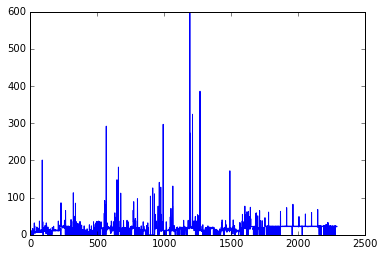

In [69]:
%matplotlib inline

import pickle
import matplotlib.pyplot as plt

datas,robotsI=3,4

startingBetws='betws{}/data_{}_betw_{}.{}'


isWithR='_lessS'

measBetws=startingBetws.format(isWithR,datas,robotsI,'meas')
grounBetws=startingBetws.format(isWithR,datas,robotsI,'groun')
with open(measBetws,"rb") as f:
    bt_Ms,abt_Ms=pickle.load(f)
with open(grounBetws,"rb") as f:
    bt_Gt=pickle.load(f)
    
plt.plot(abt_Ms[:-100])
abt_Ms